# unimib/DSIM 2025-2026 : Task 2

Dataset Exploration - E. Mosca 925279

In this notebook the PlantVillage dataset is loaded and inspected for an initial exploration. Task 2 will concern 2D signal processing for the development of a model that can correctly classify images of plants into healthy or diseased classes.

In [ ]:
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### Initial Load and Inspection

In [ ]:
path_on_gdrive = 'gdrive/My Drive/dsim/Plant_leave_diseases_dataset_without_augmentation.zip'
dataset_filename = 'Plant_leave_diseases_dataset_without_augmentation'

In [ ]:
from google.colab import drive
import zipfile
from shutil import copyfile
drive.mount('/content/gdrive')
copyfile(path_on_gdrive, dataset_filename+'.zip')
zipf = zipfile.ZipFile(dataset_filename+'.zip')
zipf.extractall()
zipf.close()

Mounted at /content/gdrive


In [ ]:
dataset = ImageFolder(root=dataset_filename, transform=transforms.ToTensor())

In [ ]:
# Stratified split into train (80%), val (10%), test (10%)
from sklearn.model_selection import train_test_split

labels = [sample[1] for sample in dataset.samples]

#80% train, 20% temp
train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# split the 20% into 50-50 for val (10%) and test (10%)
temp_labels = [labels[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

train_dataset = data.Subset(dataset, train_indices)
val_dataset = data.Subset(dataset, val_indices)
test_dataset = data.Subset(dataset, test_indices)

The dataset is structured in the following way: various folders, each representing a class, with varying amounts of images in them. No train or test split available right away

In [ ]:
#help(ImageFolder)

As can be seen below, there are multiple classes for the same type of plant(like "apple"), corresponding to any possible disease collected in the dataset, and a healthy class

In [ ]:
len(dataset.classes)

39

In [ ]:
dataset.classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

Want to systematically take a look at classes and "subclasses" with the code below

In [ ]:
classes = dataset.classes[:]

In [ ]:
import re
# split at first special character using regex, some class names are in format fruit__fruit__disease_name, but not all
tupls = [re.split(r'[_\s]', cls, maxsplit=1) for cls in classes]

In [ ]:
len(tupls)

39

In [ ]:
tupls

[['Apple', '__Apple_scab'],
 ['Apple', '__Black_rot'],
 ['Apple', '__Cedar_apple_rust'],
 ['Apple', '__healthy'],
 ['Background', 'without_leaves'],
 ['Blueberry', '__healthy'],
 ['Cherry', '__Powdery_mildew'],
 ['Cherry', '__healthy'],
 ['Corn', '__Cercospora_leaf_spot Gray_leaf_spot'],
 ['Corn', '__Common_rust'],
 ['Corn', '__Northern_Leaf_Blight'],
 ['Corn', '__healthy'],
 ['Grape', '__Black_rot'],
 ['Grape', '__Esca_(Black_Measles)'],
 ['Grape', '__Leaf_blight_(Isariopsis_Leaf_Spot)'],
 ['Grape', '__healthy'],
 ['Orange', '__Haunglongbing_(Citrus_greening)'],
 ['Peach', '__Bacterial_spot'],
 ['Peach', '__healthy'],
 ['Pepper,', 'bell___Bacterial_spot'],
 ['Pepper,', 'bell___healthy'],
 ['Potato', '__Early_blight'],
 ['Potato', '__Late_blight'],
 ['Potato', '__healthy'],
 ['Raspberry', '__healthy'],
 ['Soybean', '__healthy'],
 ['Squash', '__Powdery_mildew'],
 ['Strawberry', '__Leaf_scorch'],
 ['Strawberry', '__healthy'],
 ['Tomato', '__Bacterial_spot'],
 ['Tomato', '__Early_blight']

The classes have been correctly split based on the plant the represent, but must note that an underscore has been lost in the splitting. That's to say "Apple___Apple_scab"(3 underscores) is now split into "Apple" and "__Apple_scab"(2 underscores)

In [ ]:
cls_dict = {}
for cls in tupls:
    if cls[0] not in cls_dict.keys():
        cls_dict[cls[0]] = []
        for subcls in cls[1:]:
            cls_dict[cls[0]].append(subcls)
    else:
        cls_dict[cls[0]].append(cls[1])

In [ ]:
cls_dict.keys() #distinct plant types

dict_keys(['Apple', 'Background', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato'])

In [ ]:
len(cls_dict.keys())

15

In [ ]:
cls_dict["Apple"]

['__Apple_scab', '__Black_rot', '__Cedar_apple_rust', '__healthy']

There are different numbers of classes for each distinct plant, and there might not be both "healthy" or diseased classes for them.

In [ ]:
for k,v in cls_dict.items():
    hth = "__healthy" in [sub.lower() for sub in v] # sanity check on "healthy" spelling
    print(f"{k}: {len(v)}" + (" (has healthy)" if hth else ""))

Apple: 4 (has healthy)
Background: 1
Blueberry: 1 (has healthy)
Cherry: 2 (has healthy)
Corn: 4 (has healthy)
Grape: 4 (has healthy)
Orange: 1
Peach: 2 (has healthy)
Pepper,: 2
Potato: 3 (has healthy)
Raspberry: 1 (has healthy)
Soybean: 1 (has healthy)
Squash: 1
Strawberry: 2 (has healthy)
Tomato: 10 (has healthy)


Tomato is the plat with the most subclasses in the dataset. Something else can be noticed also.

In [ ]:
cls_dict["Orange"], cls_dict["Squash"]

(['__Haunglongbing_(Citrus_greening)'], ['__Powdery_mildew'])

We don't have healthy classes for Oranges and Squash.

In [ ]:
cls_dict["Blueberry"], cls_dict["Soybean"], cls_dict["Raspberry"]

(['__healthy'], ['__healthy'], ['__healthy'])

Inversely, we *only* have a healthy class for Blueberry, Raspberry and Soybean

Other than that, each plant is represented by at most 4 subcategories, with Tomato having 10. There is also a Background_without_leaves class.


Now, to inspect raw images (initially in PIL format)

In [ ]:
img1_raw = Image.open(dataset_filename+"/Apple___Apple_scab/image (1).JPG")

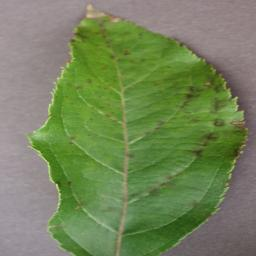

In [ ]:
img1_raw

In [ ]:
type(img1_raw)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
print("Original PIL Image Dimensions:", img1_raw.size)
print(f"The maximum pixel value is: {img1_raw.getextrema()[0][1]}, and the minimum is: {img1_raw.getextrema()[0][0]}")
print("Image channels configuration:", img1_raw.mode)

Original PIL Image Dimensions: (256, 256)
The maximum pixel value is: 209, and the minimum is: 33
Image channels configuration: RGB


From the raw PIL image it appears directly reading the JPG files leaves us with 256x256(with 3 channels, not shown in PIL format), with values that are unsigned 8-bit integers from 0 to 255.

Should check image dimensions across folders just to be sure

In [ ]:
# check image dimensions for first image in each class folder
img_dims = {}
for cls in classes:
    img_path = f"{dataset_filename}/{cls}"
    img_file = dataset.samples[dataset.class_to_idx[cls]][0]
    img = Image.open(img_file)
    img_dims[cls] = img.size
img_dims

{'Apple___Apple_scab': (256, 256),
 'Apple___Black_rot': (256, 256),
 'Apple___Cedar_apple_rust': (256, 256),
 'Apple___healthy': (256, 256),
 'Background_without_leaves': (256, 256),
 'Blueberry___healthy': (256, 256),
 'Cherry___Powdery_mildew': (256, 256),
 'Cherry___healthy': (256, 256),
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': (256, 256),
 'Corn___Common_rust': (256, 256),
 'Corn___Northern_Leaf_Blight': (256, 256),
 'Corn___healthy': (256, 256),
 'Grape___Black_rot': (256, 256),
 'Grape___Esca_(Black_Measles)': (256, 256),
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': (256, 256),
 'Grape___healthy': (256, 256),
 'Orange___Haunglongbing_(Citrus_greening)': (256, 256),
 'Peach___Bacterial_spot': (256, 256),
 'Peach___healthy': (256, 256),
 'Pepper,_bell___Bacterial_spot': (256, 256),
 'Pepper,_bell___healthy': (256, 256),
 'Potato___Early_blight': (256, 256),
 'Potato___Late_blight': (256, 256),
 'Potato___healthy': (256, 256),
 'Raspberry___healthy': (256, 256),
 'Soybean__

The dimensions seem consistent enough

Going to be using PIL and PyTorch tensors, the two share the same channel ordering (RGB). Inspecting transformation...

In [ ]:
# Using tensor
img1_tensor = transforms.ToTensor()(img1_raw)
img1_tensor.shape, img1_tensor.dtype

(torch.Size([3, 256, 256]), torch.float32)

ToTensor will return a float32 image, so min-max will be different and scaled to 0-1

In [ ]:
img1_tensor.min(), img1_tensor.max()

(tensor(0.), tensor(0.8784))

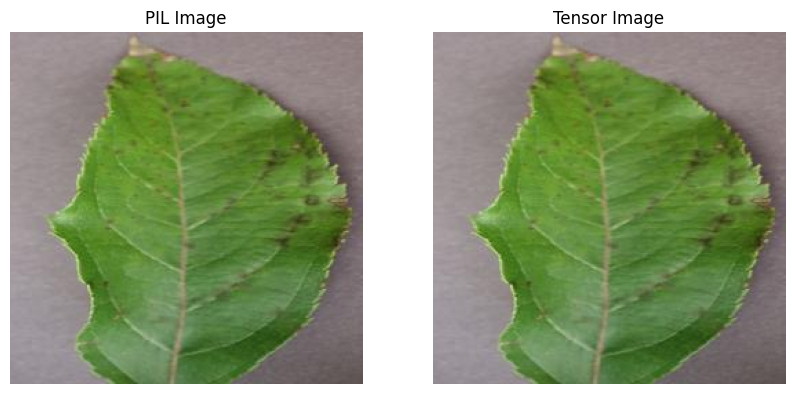

In [ ]:
# Display PIL image and PIL-backtransformed tensor image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1_raw)
ax[0].set_title("PIL Image")
ax[0].axis('off')
ax[1].imshow(transforms.ToPILImage()(img1_tensor))
ax[1].set_title("Tensor Image")
ax[1].axis('off')
plt.show()

Displaying difference between the two images...

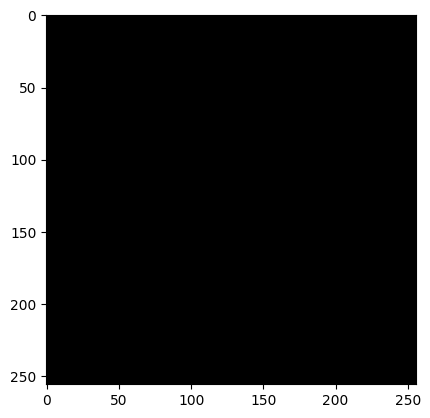

In [ ]:
# difference in images
img1_diff = np.abs(np.array(img1_raw) - np.array(transforms.ToPILImage()(img1_tensor)))
plt.imshow(img1_diff)

In [ ]:
np.abs(np.array(img1_raw) - np.array(transforms.ToPILImage()(img1_tensor))).max()

np.uint8(0)

Pretty much no difference, so no loss of info when converting between PIL and Tensor

### Dataset Characteristics

Now to get an overview on the dataset, representation of classes and other statistics/properties

In [ ]:
len(dataset) #number of entries

55448

In [ ]:
# Number of images per class, from directory structure
class_counts = {}
for cls in classes:
    cls_idx = dataset.class_to_idx[cls] # get index associated to class
    count = sum(1 for item in dataset.samples if item[1] == cls_idx) # count samples labeled with that index
    class_counts[cls] = count #add to dict
#sorting dictionary by alphabetical order of class names
class_counts = dict(sorted(class_counts.items()))

In [ ]:
cls_dict.items() #inspecting

dict_items([('Apple', ['__Apple_scab', '__Black_rot', '__Cedar_apple_rust', '__healthy']), ('Background', ['without_leaves']), ('Blueberry', ['__healthy']), ('Cherry', ['__Powdery_mildew', '__healthy']), ('Corn', ['__Cercospora_leaf_spot Gray_leaf_spot', '__Common_rust', '__Northern_Leaf_Blight', '__healthy']), ('Grape', ['__Black_rot', '__Esca_(Black_Measles)', '__Leaf_blight_(Isariopsis_Leaf_Spot)', '__healthy']), ('Orange', ['__Haunglongbing_(Citrus_greening)']), ('Peach', ['__Bacterial_spot', '__healthy']), ('Pepper,', ['bell___Bacterial_spot', 'bell___healthy']), ('Potato', ['__Early_blight', '__Late_blight', '__healthy']), ('Raspberry', ['__healthy']), ('Soybean', ['__healthy']), ('Squash', ['__Powdery_mildew']), ('Strawberry', ['__Leaf_scorch', '__healthy']), ('Tomato', ['__Bacterial_spot', '__Early_blight', '__Late_blight', '__Leaf_Mold', '__Septoria_leaf_spot', '__Spider_mites Two-spotted_spider_mite', '__Target_Spot', '__Tomato_Yellow_Leaf_Curl_Virus', '__Tomato_mosaic_virus'

/tmp/ipython-input-3990529258.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(cls_dict))


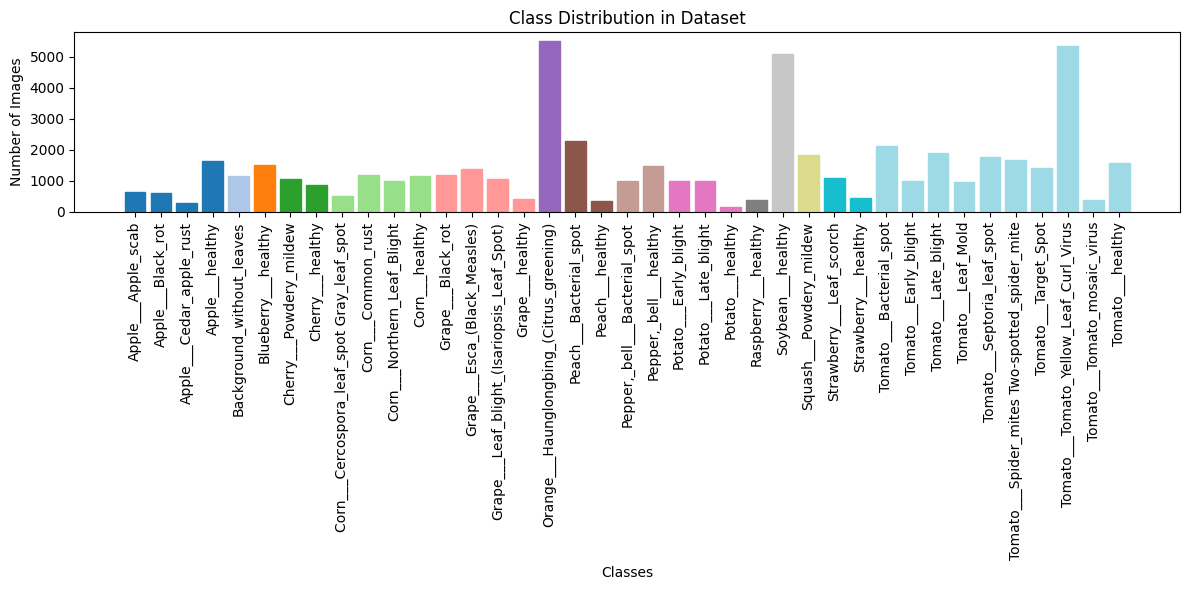

In [ ]:
#histogram of class distribution
plt.figure(figsize=(12,6))
bars = plt.bar(range(len(class_counts)), class_counts.values())
colors = plt.cm.get_cmap('tab20', len(cls_dict))

# Create a mapping from class name to plant type
class_to_plant = {}
for plant, sub_list in cls_dict.items():  #for plant, subclasses: add to dict to obtain mapping from subclass to plant
    for subcls in sub_list:
        full_name = plant+"_"+subcls #adding back the underscore lost in splitting step
        class_to_plant[full_name] = plant

# Color the bars based on plant type
plant_types = list(cls_dict.keys())
for idx, cls_name in enumerate(class_counts.keys()):
    plant = class_to_plant.get(cls_name, cls_name) # from label, obtain plant
    color_idx = plant_types.index(plant)
    bars[idx].set_color(colors(color_idx))

plt.xticks(range(len(class_counts)), class_counts.keys(), rotation=90)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.tight_layout()
plt.show()

There are 3 classes that are more prevalent and have around double the amount of images as the 4th most represented class. These classes are: the single Orange class(diseased), the single Soybean class(healthy), and one of the many tomato diseases(yellow leaf curl virus).

The 3 least frequent classes are the healthy sets of Potato and Peach, and the "Cedar apple rust" apple disease class

Next, getting a closer look at image classes can be useful

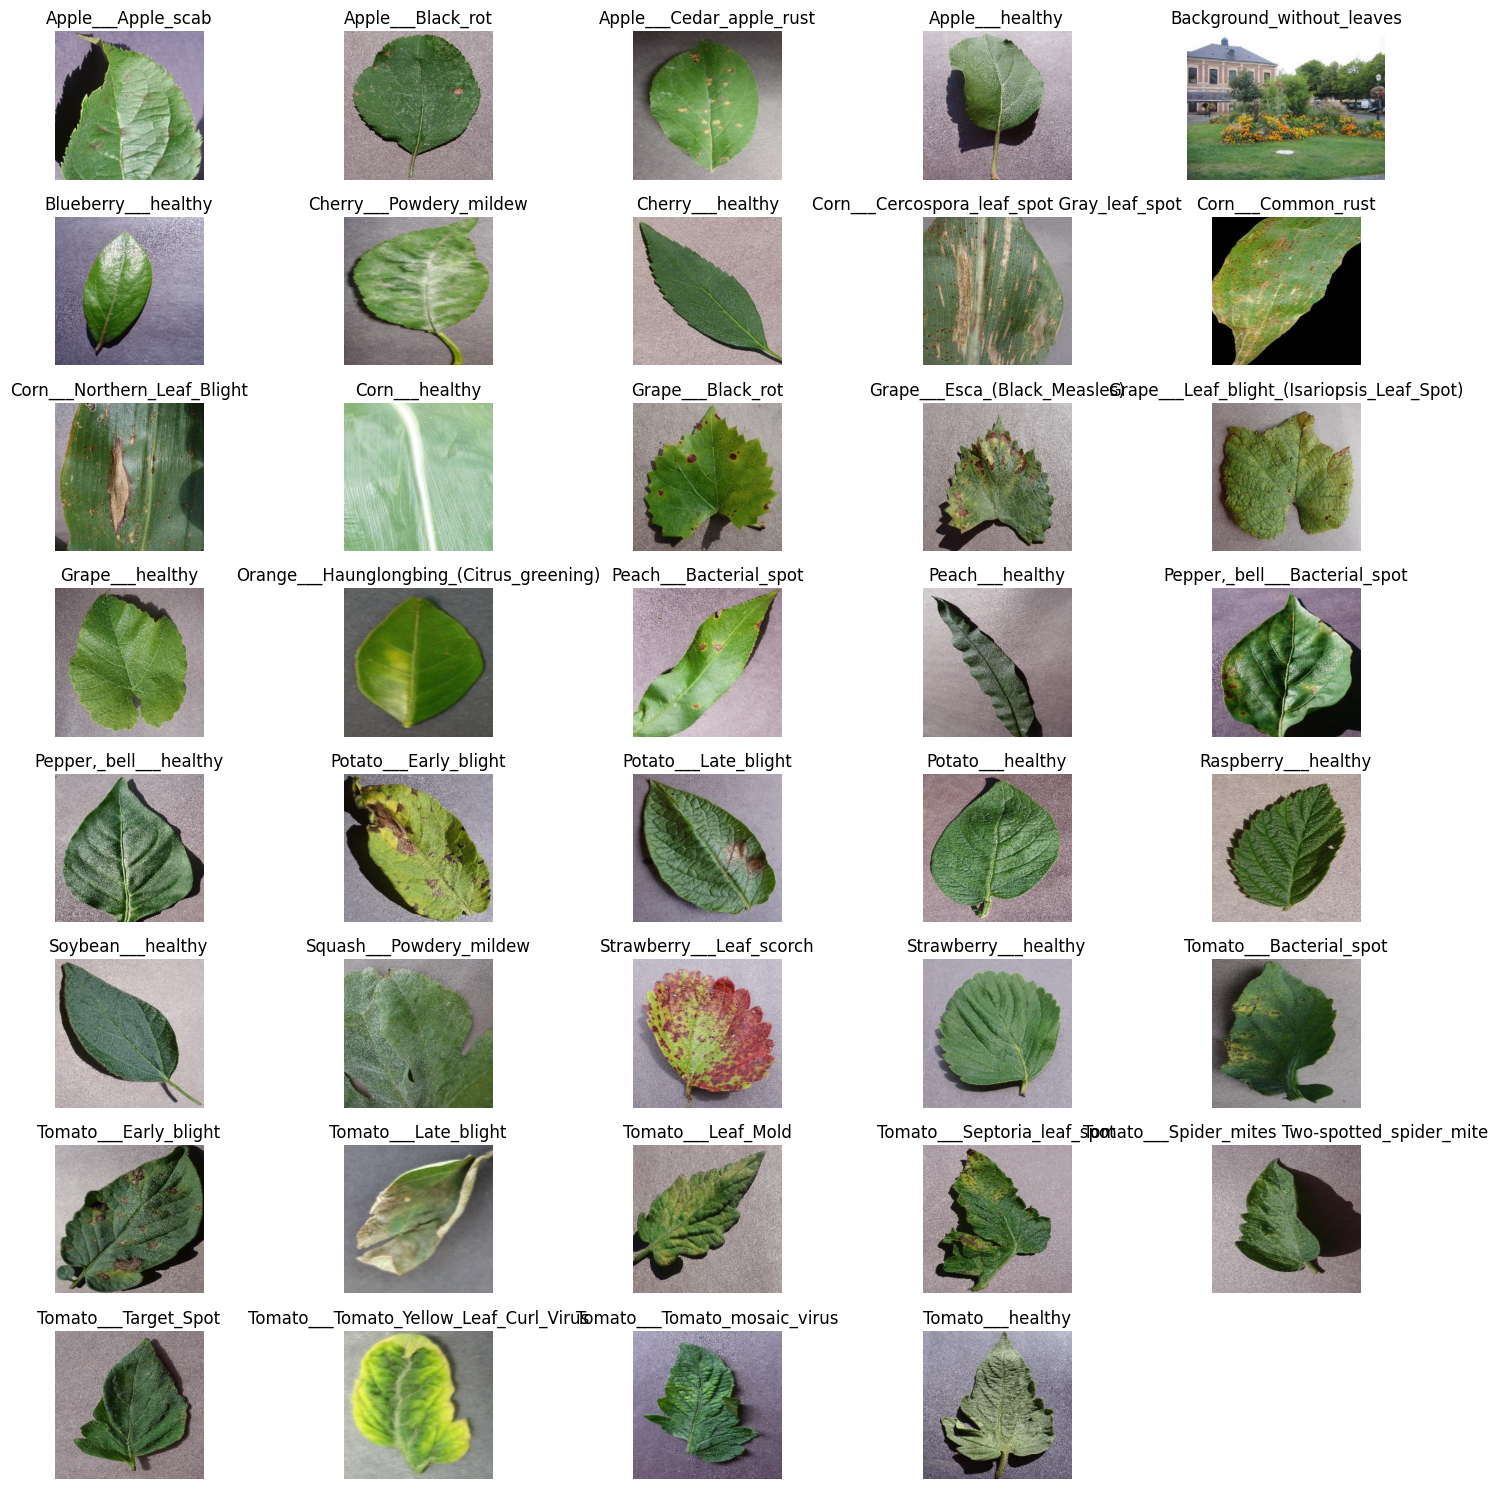

In [ ]:
#randomly plot 1 image from each class
plt.figure(figsize=(15, 15))
np.random.seed(42)
for i, cls in enumerate(classes):
    cls_idx = dataset.class_to_idx[cls]
    # Get all indices for this class
    indices = [idx for idx, item in enumerate(dataset.samples) if item[1] == cls_idx]
    rand_idx = np.random.choice(indices)
    img, label = dataset[rand_idx]
    plt.subplot(len(classes)//5 + 1, 5, i+1)
    plt.imshow(transforms.ToPILImage()(img))
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

Some details are visible from the above grid:

- Majority of leaves were photographed being placed vertically and so as to end up centered in the image; though some are tilted diagonally, slightly rotated or off-center
- Shadows are common in a number of classes, also showing how light was coming from different directions and consequently that parts of images were not lit evenly
- The two corn classes "healthy" and "common_rust" are zoomed in way more, and the background is either removed or fully dark unlike other classes, respectively
- The background_without_leaves class can still display scenes where grass, flowers, gardens, etc. are present, though not as close-up as non-background classes
- The vast majority of leaves share similar dark-green colors with their shapes being a more discriminant factor, while some diseases present more distinctive colors like bright red or yellow

The above should be considered when modeling the network(s), as they might end up classifying leaves on the basis of inprecise factors like orientation, lighting and shade etc. Image enhancement to get a better resolution, dealing with shadows and adding random rotations to handle the orientation problem in leaf classes can be useful.

The background class is quite diverse, and represents generic scenes that don't coincide with the format/modality of the other classes. This is probably the easiest class for the model to discriminate given all the others are represented by fundamentally different pictures; in a live-setting, this class might serve as a "do-nothing" class up until we get a close-up on a leaf.

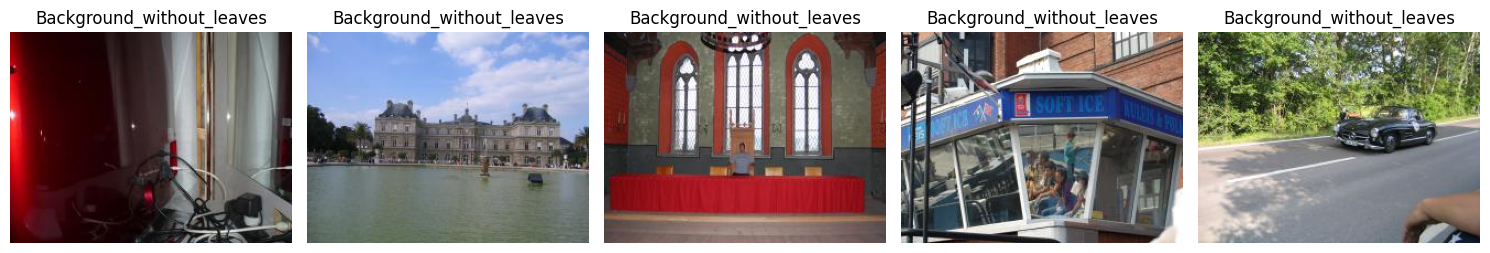

In [ ]:
# Random images of backgound_without_leaves class
bg_cls_idx = dataset.class_to_idx["Background_without_leaves"]
bg_indices = [idx for idx, item in enumerate(dataset.samples) if item[1] == bg_cls_idx]
np.random.seed(42)
rand_bg_indices = np.random.choice(bg_indices, size=5, replace=False)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(rand_bg_indices):
    img, label = dataset[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(transforms.ToPILImage()(img))
    plt.title("Background_without_leaves")
    plt.axis('off')
plt.tight_layout()
plt.show()